# Notebook for running characterizing spots on ComCam data.

Initially written 14 Nov 2019 by Craig Lage.\
Improved 02 Dec 19 adding more ISR steps

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          18.1.0-2-gb0efc0e+61 	current w_2019_47 setup


In [2]:
import sys, os, glob, time
import pickle as pkl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import eups
from lsst.daf.persistence import Butler
import lsst.afw.image as afwImage
import lsst.geom as geom
from lsst.daf.persistence import Butler
from lsst.ip.isr.isrTask import IsrTask, IsrTaskConfig
from lsst.ip.isr.isrFunctions import brighterFatterCorrection
from lsst.meas.algorithms import SourceDetectionTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.geom import Point2I, Box2I

In [3]:
REPO_DIR = '/project/shared/comCam/'
OUTPUT_DIR = '/home/cslage/ComCam/20191113J/'
raftName = 'R22'
detectorName = 'S11'
DETECTOR = 4

In [4]:
# This sets up the visits.  
starting_visit = 2019111300231
ending_visit = 2019111300279

visits = []
visit_1 = starting_visit
while visit_1 < ending_visit+1:
    visits.append(visit_1)
    visit_1 += 2 # Skipping the bias frames in between
print(visits)
print(len(visits))

[2019111300231, 2019111300233, 2019111300235, 2019111300237, 2019111300239, 2019111300241, 2019111300243, 2019111300245, 2019111300247, 2019111300249, 2019111300251, 2019111300253, 2019111300255, 2019111300257, 2019111300259, 2019111300261, 2019111300263, 2019111300265, 2019111300267, 2019111300269, 2019111300271, 2019111300273, 2019111300275, 2019111300277, 2019111300279]
25


In [58]:
# Now set up the isrConfig and charConfig 
# The master bias, flat, and dark images have already been created and ingested.
butler = Butler(OUTPUT_DIR)

isrConfig = IsrTaskConfig()
isrConfig.doLinearize = False
isrConfig.doBias = True
isrConfig.doFlat = True
isrConfig.doDark = True
isrConfig.doFringe = False
isrConfig.doDefect = False
isrConfig.doAddDistortionModel = False
isrConfig.doWrite = False
isrTask = IsrTask(config=isrConfig)

charConfig = CharacterizeImageConfig()
charConfig.installSimplePsf.fwhm = 1.0
charConfig.doMeasurePsf = False
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.doInterpolate = False   
charConfig.detection.background.binSize = 32
charConfig.detection.minPixels = 100
charTask = CharacterizeImageTask(config=charConfig)

/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/pex_config/18.1.0-6-gae77429+4/python/lsst/pex/config/config.py:1289: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)


Detected  303  objects 


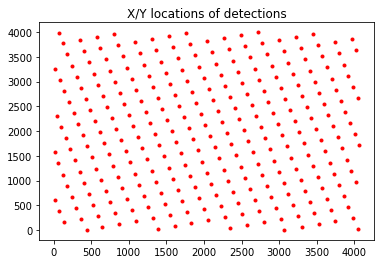

In [59]:
# First just try a single image with medium brightness
spot_visit=2019111300251
rawSpotDataRef = butler.dataRef('raw', detector=DETECTOR, visit=spot_visit)
postIsrSpot = isrTask.runDataRef(rawSpotDataRef).exposure
charResult = charTask.run(postIsrSpot)

print("Detected ",len(charResult.sourceCat)," objects ")

plt.title('X/Y locations of detections')
plt.plot(charResult.sourceCat['base_SdssCentroid_x'],charResult.sourceCat['base_SdssCentroid_y'],'r.')
plt.show()

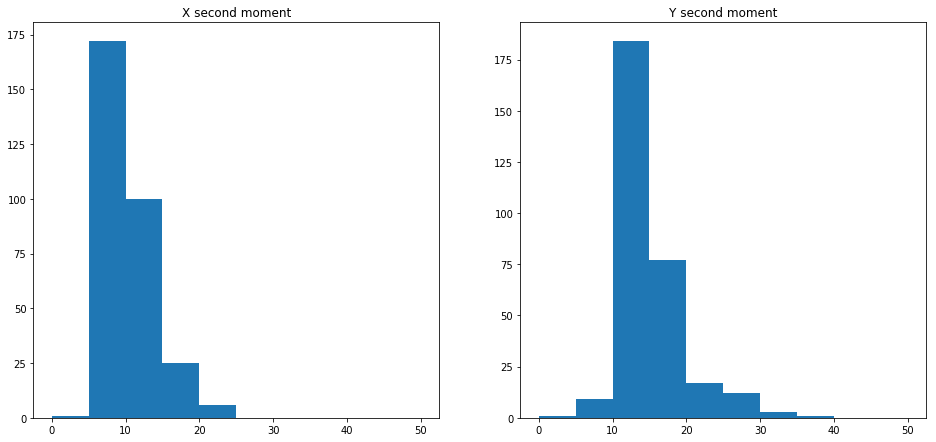

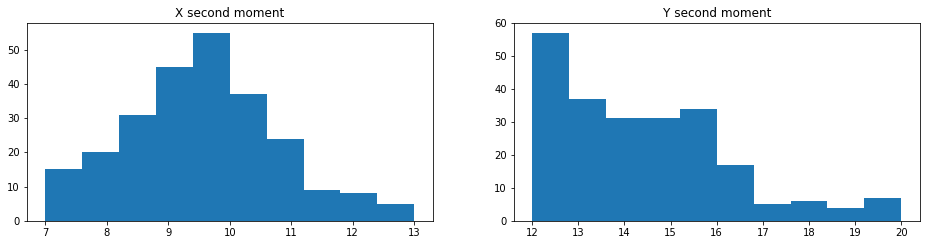

In [66]:
# Measured second moments show a lot of variability
# I'll try masking down to eliminate outliers, whatever the cause
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.title('X second moment')
plt.hist(charResult.sourceCat['base_SdssShape_xx'], range=(0.0,50.0))
plt.subplot(2,2,2)
plt.title('Y second moment')
plt.hist(charResult.sourceCat['base_SdssShape_yy'], range=(0.0,50.0))

plt.figure(figsize=(16,8))
plt.subplot(2,2,3)
plt.title('X second moment')
plt.hist(charResult.sourceCat['base_SdssShape_xx'], range=(7.0,13.0))
plt.subplot(2,2,4)
plt.title('Y second moment')
plt.hist(charResult.sourceCat['base_SdssShape_yy'], range=(12.0,20.0))

plt.show()

In [63]:
# Now we try running on all of the spot images

minSizeX = 7.0
maxSizeX = 13.0
minSizeY = 12.0
maxSizeY = 20.0
minX = minY = 500
maxX = maxY = 3500

byamp_results = []
byamp_corrected_results = []
for spot_visit in visits:
    print("Getting exposure # %d"%spot_visit)
    rawSpotDataRef = butler.dataRef('raw', detector=DETECTOR, visit=spot_visit)
    postIsrSpot = isrTask.runDataRef(rawSpotDataRef).exposure
    charResult = charTask.run(postIsrSpot)
    spotCatalog = charResult.sourceCat
    select = ((spotCatalog['base_SdssShape_xx'] >= minSizeX) & (spotCatalog['base_SdssShape_xx'] <= maxSizeX) & 
            (spotCatalog['base_SdssShape_yy'] >= minSizeY) & (spotCatalog['base_SdssShape_yy'] <= maxSizeY) &
            (spotCatalog['base_SdssCentroid_x'] >= minX) & (spotCatalog['base_SdssCentroid_x'] <= maxX) &
            (spotCatalog['base_SdssCentroid_y'] >= minY) & (spotCatalog['base_SdssCentroid_y'] <= maxY))
              
    spotCatalog  = spotCatalog.subset(select)
    x2 = spotCatalog['base_SdssShape_xx']
    y2 = spotCatalog['base_SdssShape_yy']
    flux = spotCatalog['base_SdssShape_instFlux']
    numspots = len(flux)
    print("Detected ",len(spotCatalog)," objects, Flux = %f, X2 = %f, Y2 = %f"%(np.nanmean(flux),np.nanmean(x2),np.nanmean(y2)))
    sys.stdout.flush()                                
    #if do_bf_corr:
    #    byamp_corrected_results.append([numspots, np.nanmean(flux), np.nanstd(flux), np.nanmean(x2), np.nanstd(x2),
    #                           np.nanmean(y2), np.nanstd(y2)])
    #else:
    byamp_results.append([numspots, np.nanmean(flux), np.nanstd(flux), np.nanmean(x2), np.nanstd(x2),
                               np.nanmean(y2), np.nanstd(y2)])
spots_pickle = {'results':byamp_results, 'corrected_results': byamp_corrected_results}
filename = OUTPUT_DIR+"/spots_results.pkl"
with open(filename, 'wb') as f:
    pkl.dump(spots_pickle, f)



Getting exposure # 2019111300231
Detected  151  objects, Flux = 185165.247275, X2 = 9.228151, Y2 = 14.459108
Getting exposure # 2019111300233
Detected  161  objects, Flux = 375016.817837, X2 = 9.865093, Y2 = 14.752655
Getting exposure # 2019111300235
Detected  101  objects, Flux = 561245.707764, X2 = 9.587855, Y2 = 13.768338
Getting exposure # 2019111300237
Detected  161  objects, Flux = 755541.264949, X2 = 10.368847, Y2 = 14.686490
Getting exposure # 2019111300239
Detected  161  objects, Flux = 943737.976839, X2 = 9.781736, Y2 = 15.731897
Getting exposure # 2019111300241
Detected  134  objects, Flux = 1124859.543154, X2 = 9.619494, Y2 = 13.851827
Getting exposure # 2019111300243
Detected  159  objects, Flux = 1305882.601063, X2 = 9.690706, Y2 = 14.482888
Getting exposure # 2019111300245
Detected  133  objects, Flux = 1492768.991048, X2 = 9.381327, Y2 = 13.862868
Getting exposure # 2019111300247
Detected  156  objects, Flux = 1686586.760286, X2 = 9.611566, Y2 = 14.282133
Getting exposu

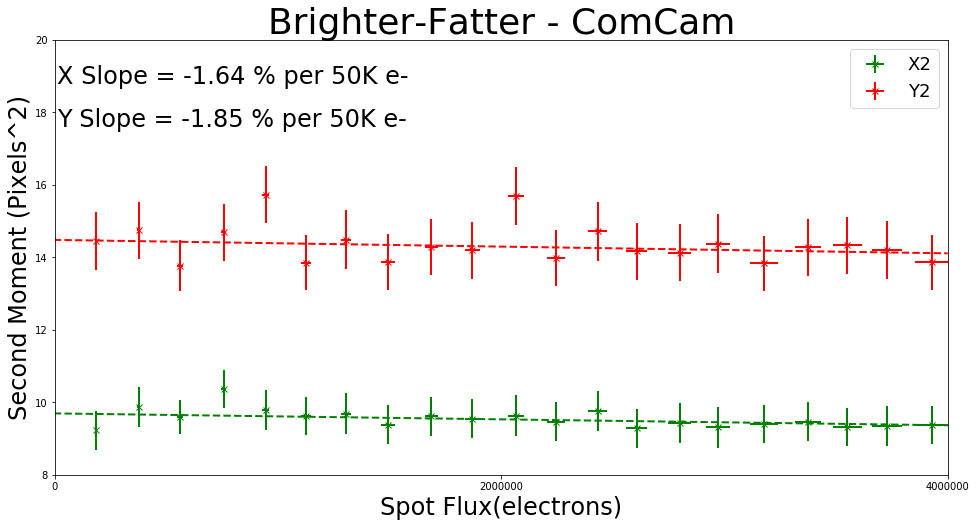

In [68]:
# Now plot the result
from scipy import stats
plotCorrection=False
syst_fraction = 0.5
min_slope_index = 5
max_slope_index = len(byamp_results) - 1
max_flux_index = len(byamp_results)
minSpot = 8.0
maxSpot = 20.0
#with open(filename, 'rb') as f:
#    spots_pickle= pkl.load(f)

textDelta = (maxSpot - minSpot) / 10
# These next are in case not all fluxes produced good results
#byamp_results = spots_pickle['results']
try:
    results = np.array([byamp_results[i] for i in range(max_flux_index)])
    max_slope_ind = max_slope_index
except:
    results = np.array(byamp_results)
    max_slope_ind = min(len(results) - 4, max_slope_index)
xerror = results[:,2]/np.sqrt(results[:,0])
xyerror = results[:,4] * (syst_fraction + (1 - syst_fraction) / np.sqrt(results[:,0]))
yyerror = results[:,6] * (syst_fraction + (1 - syst_fraction) / np.sqrt(results[:,0]))

if plotCorrection:
    byamp_corrected_results = spots_pickle['corrected_results']
    try:
        corrected_results = np.array([byamp_corrected_results[i] for i in range(max_flux_index)])
        max_slope_ind_corr = max_slope_index
    except:
        corrected_results = np.array(byamp_corrected_results)           
        max_slope_ind_corr = min(len(corrected_results) - 4, max_slope_index)

    corrected_xerror = corrected_results[:,2]/np.sqrt(corrected_results[:,0])
    corrected_xyerror = corrected_results[:,4] * (syst_fraction + (1 - syst_fraction) / np.sqrt(corrected_results[:,0]))
    corrected_yyerror = corrected_results[:,6] * (syst_fraction + (1 - syst_fraction) / np.sqrt(corrected_results[:,0]))

plt.figure(figsize=(16,8))
plt.title("Brighter-Fatter - ComCam", fontsize = 36)
# First plot the uncorrected data
plt.errorbar(results[:,1], results[:,3], xerr = xerror, 
             yerr = xyerror, color = 'green', lw = 2, label = 'X2', ls='', marker='x')
plt.errorbar(results[:,1], results[:,5], xerr = xerror, 
             yerr = yyerror, color = 'red', lw = 2, label = 'Y2', ls='',marker='x')
slope, intercept, r_value, p_value, std_err = stats.linregress(results[min_slope_index:max_slope_ind,1], results[min_slope_index:max_slope_ind,3])
xplot=np.linspace(-5000.0,4000000.0,100)
yplot = slope * xplot + intercept
plt.plot(xplot, yplot, color='green', lw = 2, ls = '--')
tslope = slope * 100.0 * 200000.0
plt.text(10000.0,maxSpot-textDelta,"X Slope = %.2f %% per 50K e-"%tslope, fontsize=24)

slope, intercept, r_value, p_value, std_err = stats.linregress(results[min_slope_index:max_slope_ind,1], results[min_slope_index:max_slope_ind,5])
xplot=np.linspace(-5000.0,4000000.0,100)
yplot = slope * xplot + intercept
plt.plot(xplot, yplot, color='red', lw = 2, ls = '--')
tslope = slope * 100.0 * 200000.0
plt.text(10000.0,maxSpot-2*textDelta,"Y Slope = %.2f %% per 50K e-"%tslope, fontsize=24)

if plotCorrection:
    # Now plot the corrected data
    plt.errorbar(corrected_results[:,1], corrected_results[:,3], xerr = corrected_xerror, 
                yerr = corrected_xyerror, color = 'cyan', lw = 2, label = 'Corrected X2')
    plt.errorbar(corrected_results[:,1], corrected_results[:,5], xerr = corrected_xerror,
                yerr = corrected_yyerror, color = 'magenta', lw = 2, label = 'Corrected Y2')
    slope, intercept, r_value, p_value, std_err = stats.linregress(corrected_results[min_slope_index:max_slope_ind_corr,1], corrected_results[min_slope_index:max_slope_ind_corr,3])
    xplot=np.linspace(-5000.0,3200000.0,100)
    yplot = slope * xplot + intercept
    plt.plot(xplot, yplot, color='cyan', lw = 2, ls = '--')
    tslope = slope * 100.0 * 200000.0
    plt.text(10000.0,maxSpot-3*textDelta,"Corrected X Slope = %.2f %% per 50K e-"%tslope, fontsize=24)

    slope, intercept, r_value, p_value, std_err = stats.linregress(corrected_results[min_slope_index:max_slope_ind_corr,1], corrected_results[min_slope_index:max_slope_ind_corr,5])
    xplot=np.linspace(-5000.0,3200000.0,100)
    yplot = slope * xplot + intercept
    plt.plot(xplot, yplot, color='magenta', lw = 2, ls = '--')
    tslope = slope * 100.0 * 200000.0
    plt.text(10000.0,maxSpot-4*textDelta,"Corrected Y Slope = %.2f %% per 50K e-"%tslope, fontsize=24)

plt.xlim(0.0,4000000.0)
plt.xticks([0,2000000,4000000])
plt.ylim(minSpot, maxSpot)
plt.xlabel('Spot Flux(electrons)',fontsize=24)
plt.ylabel('Second Moment (Pixels^2)',fontsize=24)
plt.legend(loc= 'upper right',fontsize = 18)
plt.savefig(OUTPUT_DIR+"plots/BF_Slopes_02Dec19.pdf")
